In [1]:
import os, sys

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood

os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'
numpyro.set_host_device_count(10)

import jax
import jax.numpy as jnp
from jax import random

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from model import *

plt.rcParams['font.size'] = 14
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['axes.axisbelow'] = True


jax.device_count()

/Users/murakami/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


10

## データの読み込みと前処理

1455


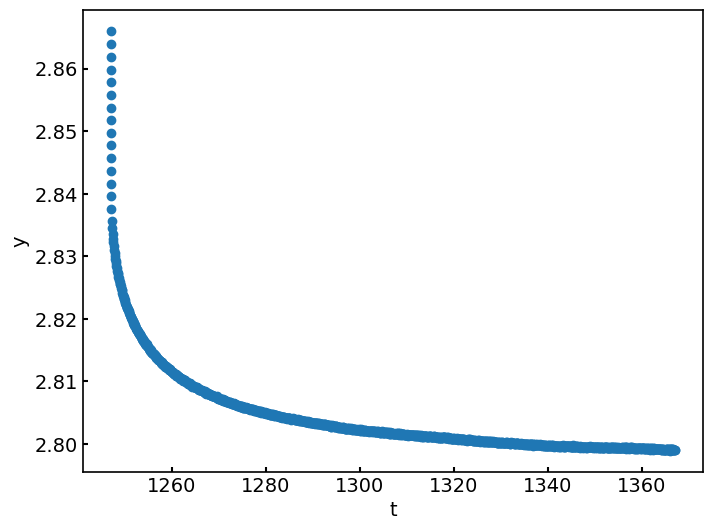

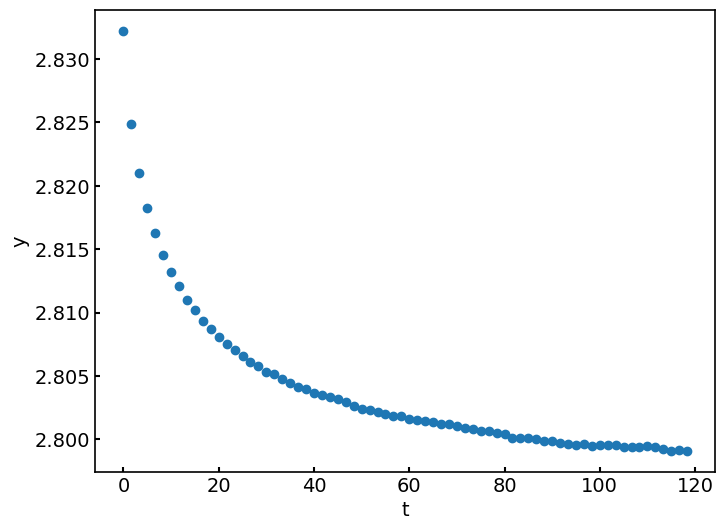

In [2]:
data = np.loadtxt('../data/1.csv', skiprows=1, delimiter=',')

t = data[:, 0]
y_obs = data[:, 1]

print(len(t))

plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs)
plt.xlabel('t'); plt.ylabel('y')
plt.show()

mask = t > 1247.5
t = t[mask] - np.min(t[mask])
y_obs = y_obs[mask]

t = t[::20]
y_obs = y_obs[::20]

plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs)
plt.xlabel('t'); plt.ylabel('y')
plt.show()

## 時定数空間の設定

In [3]:

# 離散化されたτ空間（例: 対数スケールで10^-1 ～ 10^2）
N = 500
tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)


## 解析の開始

In [4]:
num_samples = num_warmup = 1000
num_chains = 10
K_max = 5
result_dict = {'K' : [], 'BIC' : [], 'NLL' : [], 'd' : []}
mcmc_list = []
for k in range(1, K_max+1):
    
    kernel = NUTS(model, target_accept_prob=0.95, step_size=1)
    mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=3*num_warmup, num_chains=num_chains, progress_bar=False)
    mcmc.run(random.PRNGKey(1), t=t, y_obs=y_obs, tau=tau, K=k)
    # mcmc.print_summary()

    log_likelihood_dict = log_likelihood(
        model=model, posterior_samples=mcmc.get_samples(), 
        t=t, y_obs=y_obs, tau=tau, K=k)
    nll = -1.0 * jnp.sum( log_likelihood_dict['obs'], axis=1)
    nll_map = np.min(nll).item()
    ndata = len(t)
    parameter_size = k * 3 + 2
    bic = 2.0 * nll_map + parameter_size * np.log(ndata)
    print(f'bic={bic}, nll={nll_map}, d={parameter_size}')
    
    result_dict['K'].append(k)
    result_dict['BIC'].append(bic)
    result_dict['NLL'].append(nll_map)
    result_dict['d'].append(parameter_size)
    mcmc_list.append(mcmc)

bic=-896.0804145221073, nll=-458.73187255859375, d=5
bic=-1120.7844737822466, nll=-577.4989013671875, d=8
bic=-1103.1541824564483, nll=-575.0987548828125, d=11
bic=-1082.6415669119003, nll=-571.2574462890625, d=14
bic=-1082.4440148439146, nll=-577.5736694335938, d=17


In [5]:
result_df = pd.DataFrame(result_dict)

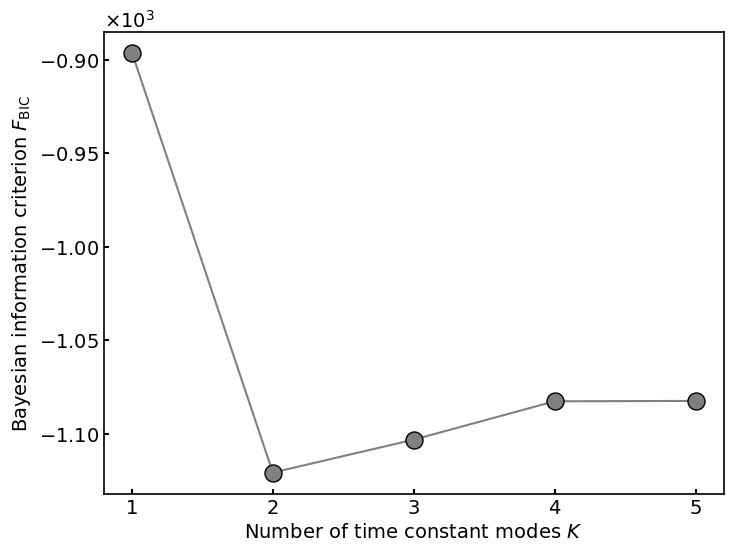

In [6]:
plt.figure(figsize=(8, 6))
from matplotlib.ticker import ScalarFormatter
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
plt.plot(result_dict['K'], result_dict['BIC'], color='gray', zorder=1)
plt.scatter(result_dict['K'], result_dict['BIC'], 
            s=150, edgecolor='k', color='gray', zorder=2)
plt.xticks(range(1, K_max+1), range(1, K_max+1))
plt.xlabel(r'Number of time constant modes $K$')
plt.ylabel(r'Bayesian information criterion $F_\mathrm{BIC}$')

plt.show()

In [7]:
mcmc = mcmc_list[1]

In [8]:
sorted_index = np.argsort( mcmc.get_samples()['mu'] )
samples = mcmc.get_samples()

In [9]:
sorted_samples = {}
keys = ['h', 'mu', 'sigma']
for key in keys:
    samples_k = []
    for i, j in enumerate(sorted_index):
        samples_k.append( samples[key][i, j] )
    samples_k = np.array( samples_k )
    sorted_samples[key] = samples_k

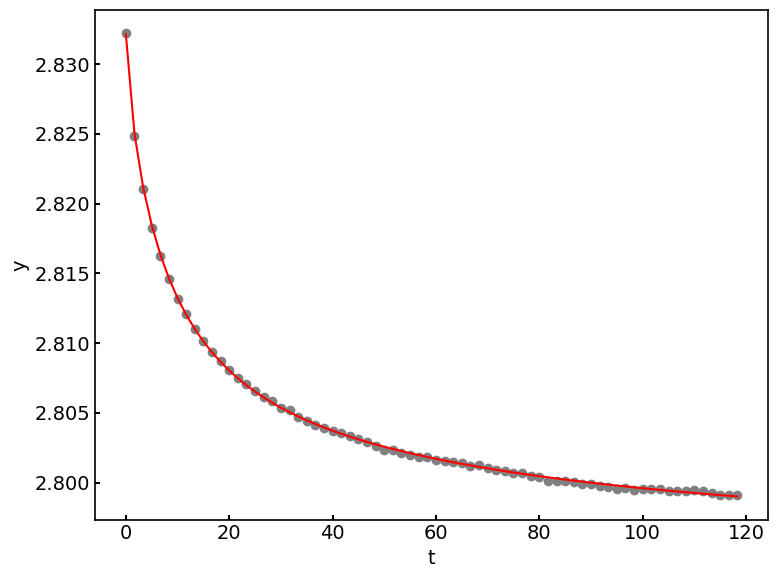

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs, c='gray')
plt.plot(t, mcmc.get_samples()['f'][-1, :], color='r')
plt.xlabel('t');plt.ylabel('y')
plt.tight_layout()
plt.show()

<function function.__dir__()>

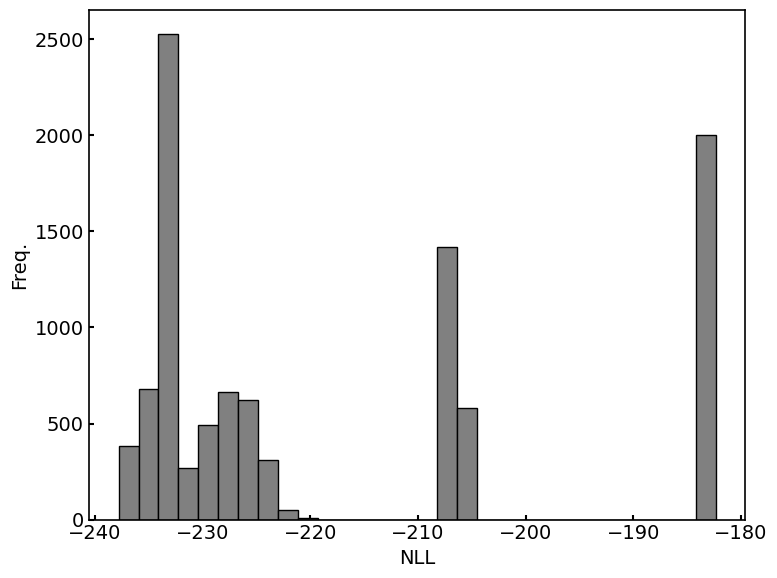

In [11]:
# plt.figure(figsize=(7, 7))

# # plt.vlines(x=mu_true[0], ymin=tau.min(), ymax=tau.max(), zorder=0.1, ls='--', alpha=0.5)
# # plt.hlines(y=mu_true[1], xmin=tau.min(), xmax=tau.max(), zorder=0.2, ls='--', alpha=0.5)

# plt.scatter(sorted_samples['mu'][:, 0], sorted_samples['mu'][:, 1], alpha=0.1, c='gray', s=10, zorder=1)

# plt.xlabel(r'$\mu_1$')
# plt.ylabel(r'$\mu_2$')
# plt.xlim(tau.min(), tau.max())
# plt.ylim(tau.min(), tau.max())
# plt.tight_layout()
# plt.show()

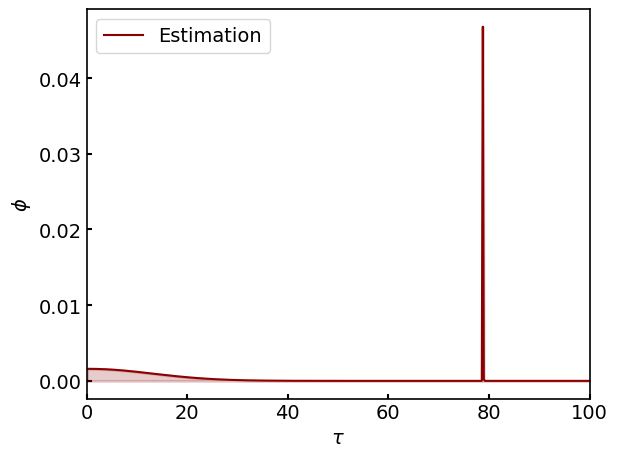

In [12]:
argmin_nll = np.argmin(nll)
tcd = np.zeros( len(tau) )
K = 2
for k in range(K):
    est_sigma = np.mean( samples['sigma'][argmin_nll, k] )
    est_mean = np.mean( samples['mu'][argmin_nll, k] )
    est_height = np.mean( samples['h'][argmin_nll, k] )
    
    tcd += ( est_height * gaussian(tau, est_mean, est_sigma) )
    
plt.plot(tau, tcd, color='darkred', label='Estimation')
plt.fill_between(tau, tcd, color='darkred', alpha=0.2, lw=2)


plt.legend()
plt.xlim(0, 100)
# plt.ylim(0, 1.5)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.tight_layout()
plt.show()

In [23]:
areas = []
positions = []
for k in range(K):
    est_sigma = np.mean( samples['sigma'][argmin_nll, k] )
    est_mean = np.mean( samples['mu'][argmin_nll, k] )
    est_height = np.mean( samples['h'][argmin_nll, k] )
    # 各ガウス関数の面積を計算
    area = est_height * est_sigma * np.sqrt(2.0 * np.pi)
    areas.append(area)
    positions.append(est_mean)

# 全体の面積
total_area = sum(areas)

# 面積分率（各ガウス関数の面積 / 全体の面積）
area_fractions = [area / total_area for area in areas]

# 結果を表示
for i, fraction in enumerate(area_fractions):
    print(f"ガウス関数 (position={positions[i]:.2f}) の面積分率: {fraction:.4f}")

ガウス関数 (position=78.84) の面積分率: 0.2123
ガウス関数 (position=0.42) の面積分率: 0.7877


In [13]:
# plt.figure(figsize=(7, 7))
# plt.scatter(samples['b'], sorted_samples['mu'][:, 0], 
#                     alpha=0.01, c='darkred', s=20)
# plt.scatter(samples['b'], sorted_samples['mu'][:, 1], 
#                     alpha=0.01, c='darkblue', s=20)
# plt.xlabel(r'$b$')
# plt.ylabel(r'$\mu$')
# # plt.xlim(tau.min(), tau.max())
# plt.ylim(tau.min(), tau.max())
# plt.tight_layout()
# plt.show()

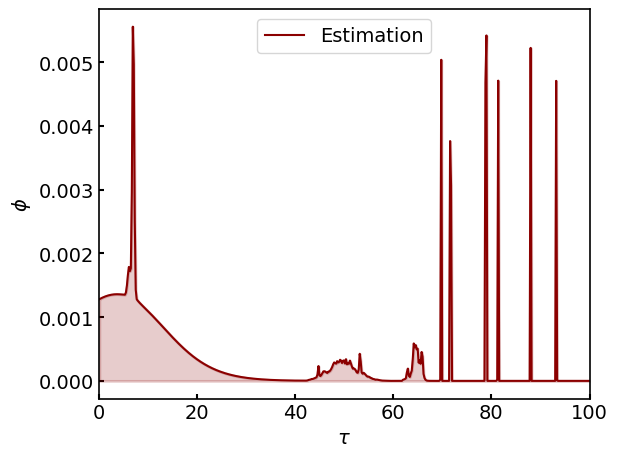

In [14]:
sum_tcd = np.zeros( len(tau) )
draw_samples = np.arange(1, num_chains*num_samples)
for j in draw_samples:
    tcd = np.zeros( len(tau) )
    for k in range(K):
        est_sigma = np.mean( samples['sigma'][-j, k] )
        est_mean = np.mean( samples['mu'][-j, k] )
        est_height = np.mean( samples['h'][-j, k] )
        
        tcd += ( est_height * gaussian(tau, est_mean, est_sigma) )
    
    sum_tcd += ( tcd / len(draw_samples) ) 

plt.plot(tau, sum_tcd, color='darkred', label='Estimation')
plt.fill_between(tau, sum_tcd, color='darkred', alpha=0.2, lw=2)

plt.legend()
plt.xlim(0, 100)
# plt.ylim(0, 1.5)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.tight_layout()
plt.show()